# Выпускной проект. Телеком: исследование оттока клиентов

## Глава 0. Входные данные

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  

### Описание услуг

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 

Также доступны такие услуги:
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.  

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

### План проекта

Предстоит построить прототип модели машинного обучения. Его разработка состоит из нескольких этапов:
- **Составьте план работы**. Исходное условие задачи заведомо неполное и содержит лишнюю информацию. Проведите исследовательский анализ данных, чтобы понять, какие вопросы подготовить. Составите примерный план решения задачи. Опишите 3–5 основных шагов, каждый пояснить не более двумя предложениями.
- **Уточните задачу**. Задайте вопросы тимлиду.
- **Разработайте модель**. Отдайте код на проверку ревьюверу.
- **Подготовьте отчёт**. Отправьте отчёт тимлиду, чтобы он проверил успешность выполнения задания.  


## Глава 1. Исследовательский анализ данных

Импортируем библиотеки, необходимые для реализации проекта:

In [73]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
sns.set()

Для создания ДатаФреймов напишем функцию `create_df`, для первого обзора данных - `first_view`.

In [74]:
# в тренажере
# def create_df(data):
#      return pd.read_csv('/datasets/final_provider/' + data)

# локально
def create_df(data):
    return pd.read_csv('final_provider/' + data)

df_contract = create_df('contract.csv')
df_personal = create_df('personal.csv')
df_internet = create_df('internet.csv')
df_phone = create_df('phone.csv')

In [75]:
def first_view(df):
    print(df.info())
    return df

Сделаем первичный анализ данных данных:

In [76]:
first_view(df_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


- В данных нет пропусков при первичном анализе
- **BeginDate** и **EndDate** данные не в формате Даты. **EndDate** если клиент ушел отмечена дата, если нет указано No(целевой признак)
- Бинарные признак перевести в (0, 1), в категориальных определить количество категорий и ранжировать
- По дате определить количество месяцев(дней) сотрудничества
- Данные представлены на 01-02-2020. Значит для тех кто не ушел, No в **EndDate** заменим на эту дату
- **TotalCharges** перевести в числовой тип

In [77]:
first_view(df_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


- пропусков нет
- Признаки:
    - Gender - пол. 
    - SeniorCitizen - пенсионер
    - Partner - Есть ли партнер
    - Dependents - Дети
- Бинарные признаки перевести в (0, 1) 

In [78]:
first_view(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


- Данные не по всем клиентам, значит интернетом пользуются только эти пользователи.
- Пропусков нет
- значения бинарных признаков перевести в (0, 1)

По предоставленным данным:  
`InternetService` - интернет - подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)  
`OnlineSecurity` - блокировка небезопасных сайтов  
`OnlineBackup` - облачное хранилище файлов для резервного копирования данных  
`DeviceProtection` - антивирус  
`TechSupport` - выделенная линия технической поддержки  
`StreamingTV` - стриминговое телевидение   
`StreamingMovies` - каталог фильмов  

In [79]:
first_view(df_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


- Пользователи телефонной линии (общее количество)
- MultipleLines - подключение телефонного аппарата к нескольким линиям одновременно
- Бинарный признак перевести в (0, 1)

Добавим целевой признак *Сhurn* - отток клиента. Если в признаке **EndDate** присутствует дата, значит клиент ушел (1), иначе нет (0)

In [80]:
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')

Так же известно, что если клиент не ушел, то он продолжает пользоваться услугами на момент 01-02-2020. Заменим *No* на эту дату в признаке **EndDate**

In [81]:
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

Переведем признаки с датой в формат даты:

In [82]:
def date_convert(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

date_convert(df_contract, 'BeginDate')
date_convert(df_contract, 'EndDate')

Найдем разницу в днях между **BeginDate** и	**EndDate**:

In [83]:
df_contract['duration_in_days'] = (df_contract['EndDate'] - df_contract['BeginDate']).astype('timedelta64[D]')
df_contract['duration_in_days'] = df_contract['duration_in_days'].astype('int')

Изменим порядок столбцов:

In [84]:
cols = df_contract.columns.tolist()
cols = cols[:-2] + cols[-1:] + [cols[-2]]

In [85]:
df_contract = df_contract[cols]
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration_in_days,Churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,1036,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Yes
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,730,No
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,2191,No
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,337,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,123,Yes


Переведем **TotalCharges**  в числовой тип:

In [86]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [87]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
duration_in_days    7043 non-null int32
Churn               7043 non-null object
dtypes: datetime64[ns](2), float64(2), int32(1), object(5)
memory usage: 522.8+ KB


Пропуски появились для 11 клиентов. Посмотрим кто они

In [88]:
df_contract.sort_values(by='TotalCharges').tail(11)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration_in_days,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,No
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,No
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,No
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,No
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,No


Это клиенты, которые только что подключились, не прошло и дня. Заполним пропуски в **TotalCharges** на значения **MonthlyCharges**

In [89]:
NaN_indexes = df_contract.sort_values(by='TotalCharges').tail(11)['TotalCharges'].index

In [90]:
df_contract.loc[NaN_indexes]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration_in_days,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,No
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,No
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,No
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,No
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,No


Применим `np.where` чтобы заполнить пропуски:

In [91]:
df_contract['TotalCharges'] = np.where(df_contract['TotalCharges'] > 0, \
                                       df_contract['TotalCharges'], df_contract['MonthlyCharges'])

In [92]:
df_contract.loc[NaN_indexes]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration_in_days,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,0,No
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,0,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,0,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,0,No
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,0,No
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,0,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,0,No
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.00,0,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.70,0,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35,0,No


Найдем уникальные значения для категориальных признаков:

In [93]:
df_contract_categorial = list(df_contract.columns)[3:6]
df_contract_categorial.append('Churn')
df_contract_categorial

['Type', 'PaperlessBilling', 'PaymentMethod', 'Churn']

In [94]:
for i in df_contract_categorial:
    print(i, df_contract[i].unique())

Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


Тип оплаты - 3 категории,  
Безбумажный счет - бинарный,  
Метод оплаты - 4 категории,  
Целевой признак (отток) - бинарный

Напишем функцию **categorial_feature_distribution**, строящую график распределения категориального признака:

In [95]:
def categorial_feature_distribution(df, column):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.xticks(rotation=0)
    sns.countplot(x=column, data=df, palette='coolwarm')
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Количество');

Построим графики категориальных признаков в **df_contract**

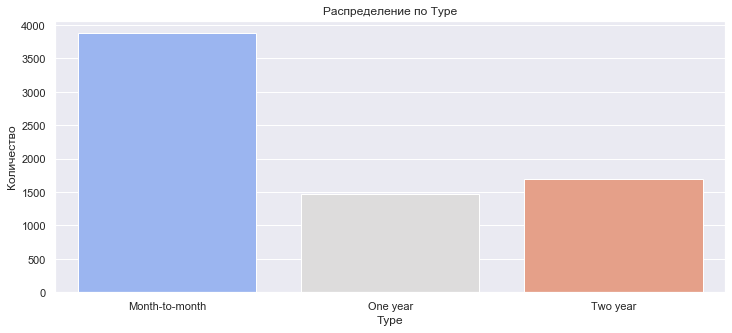

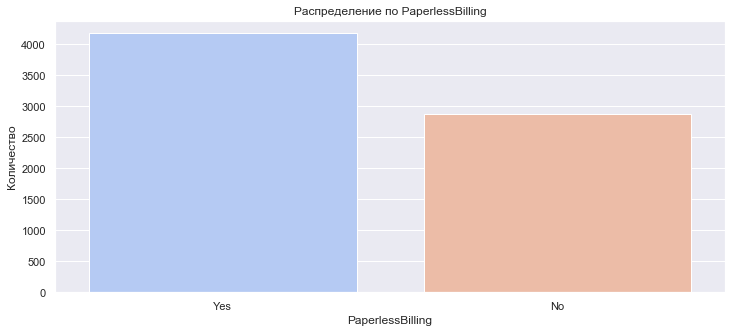

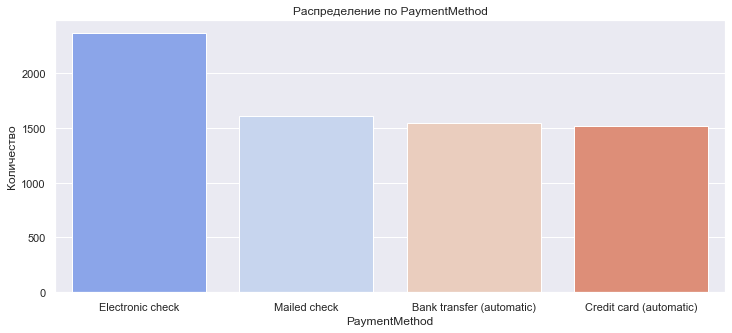

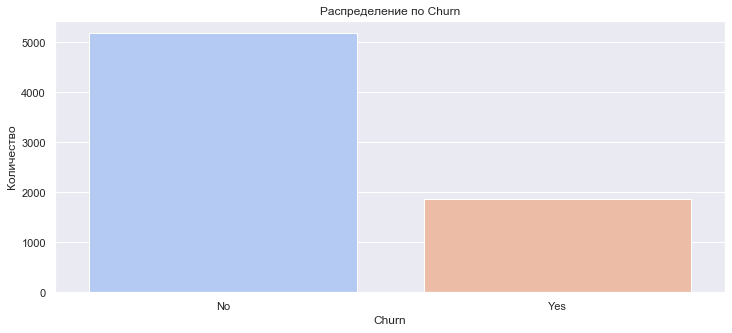

In [96]:
[categorial_feature_distribution(df_contract, item) for item in df_contract_categorial];

Выводы:
- Основной метод оплаты - *Month-to-month* используют примерно 50% пользователей, два других *One yea* и *Two year* используют примерно по 25% пользователей
- Использование безбумажной оплаты более популярно
- *Electronic check* больше всего используется, *Mailed check*, *Credit card (automatic)*, *Bank transfer (automatic)* примерно одинаково
- Отток клиентов по сравнению с лояльными достаточно высок(больше 1/3).

Напишем функцию **numeric_feature_distribution**, строящую график распределения количественного признака:

In [97]:
def numeric_feature_distribution(df, column):
    sns.set()
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.distplot(df[column])
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Плотность частоты');

Определим количественные признаки в **numeric_features**

In [98]:
numeric_features = list(('MonthlyCharges', 'TotalCharges', 'duration_in_days'))

Построим графики количественных признаков в **df_contract**

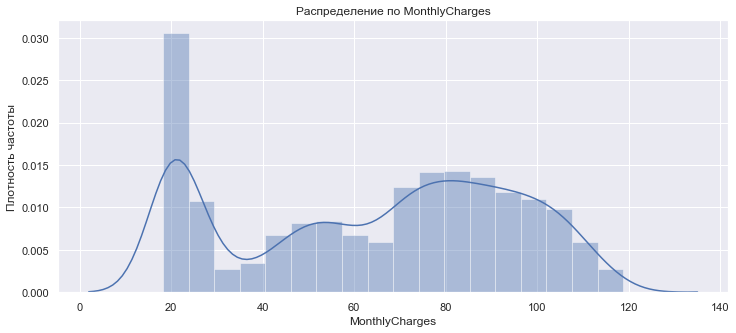

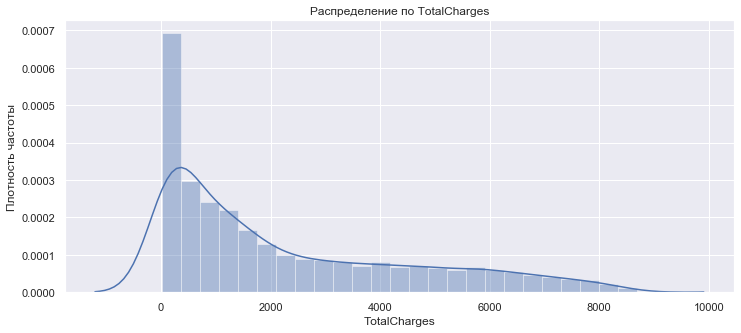

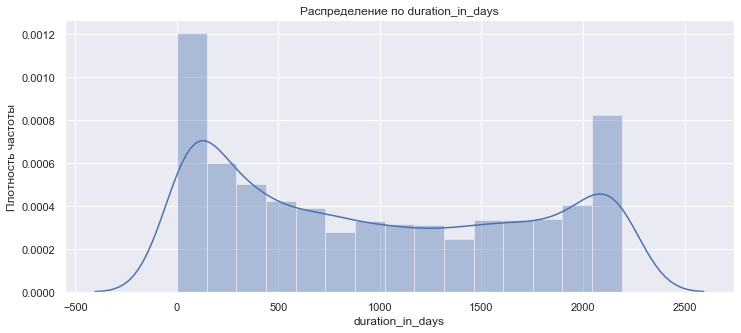

In [99]:
[numeric_feature_distribution(df_contract, item) for item in numeric_features];

Напишем функцию `boxplot_distribution`, строящую boxplot

In [100]:
def boxplot_distribution(df, column):
    plt.figure(figsize=(15,3))
    sns.boxplot(df[column], color='g').set(xlabel='Значения', ylabel=column)                          
    plt.title(label='"Ящик с усами" по ' + column, fontdict={'fontsize': 18})
    plt.show()

Построим boxplot для количественных признаков в **df_contract**

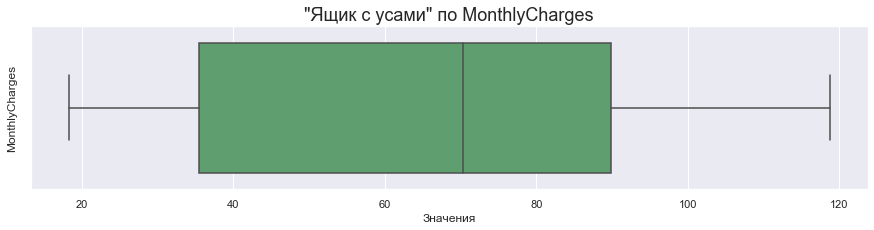

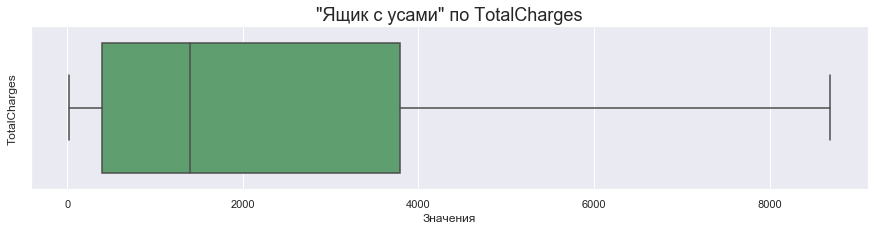

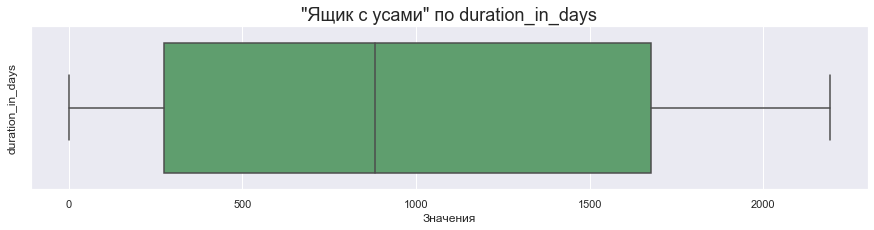

In [101]:
[boxplot_distribution(df_contract, item) for item in numeric_features];

И выведем численное описание:

In [102]:
for item in numeric_features:
    print(df_contract[item].describe())
    print()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: duration_in_days, dtype: float64



Выводы:
- **MonthlyCharges** - распределен бимодально, всплески около 20 и 80
- **TotalCharges** - нормальное распределение с положительным смещением
- **duration_in_days** - распределен бимодально, два всплеска - кто пользовался меньше полугода, тех кто больше 3 лет
- бимодальность также означает, что у нас как минмиум две выборки в одной. А значит есть фактор, который этому способствует.

Посмотри как эти признаки коррелируют между собой, с разделением на тех кто ушел и лояльных.  
Построим `pairplot`

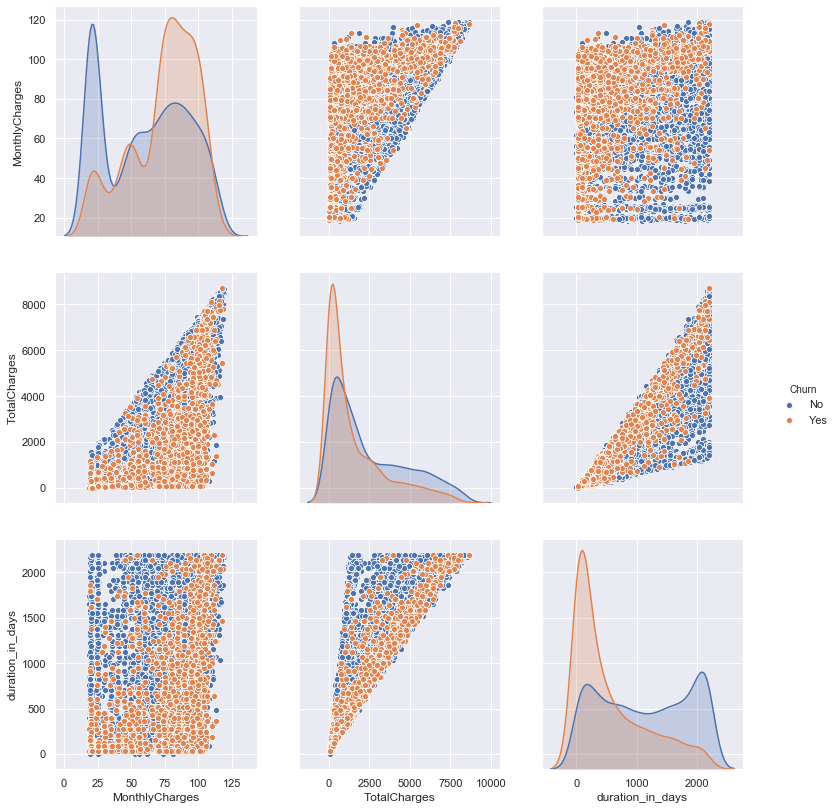

In [103]:
sns.pairplot(df_contract, hue='Churn').fig.set_size_inches(12,12)

In [104]:
df_contract.corr()

,MonthlyCharges,TotalCharges,duration_in_days
MonthlyCharges,1.000000,0.651182,0.247754
TotalCharges,0.651182,1.000000,0.826095
duration_in_days,0.247754,0.826095,1.000000


Выводы:
- **MonthlyCharges** - видно что уходят в основном те, кто получает большие счета за услуги, что логично
- **TotalCharges** - почти одинаково распределен для тех кто ушел и кто лоялен
- **duration_in_days** - уходят в основном на первых месяцах, для лояльных примерно равномерно
- Сильно коррелируют **duration_in_days** и **TotalCharges** (линейно-зависимы, чуть слабее **MonthlyCharges** и **TotalCharges**(те, кто тратит на услуги больше, в целом приносит соответственно много дохода компании)

Напишем функцию `categorial_countplot` для построения распределения категориальных признаков с разрезе ушел клиент или лоялен:

In [105]:
def categorial_countplot(df, categories, nrows, ncols, size=15, rotation=0):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size))
    if nrows == 1 and ncols ==1:
        sns.countplot(df[categories], hue='Churn', data=df, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
        ax.set_title('Распределение по ' + categories)
        ax.set_ylabel('Количество');  
    
    elif nrows == 1:
        for idx, feat in enumerate(categories):
            sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx])
            ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=rotation)
            ax[idx].set_title('Распределение по ' + feat)
            ax[idx].set_ylabel('Количество');  
    
    else:
        for idx, feat in enumerate(categories):
            sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx // ncols, idx % ncols])
            ax[idx//ncols, idx%ncols].set_xticklabels(ax[idx//ncols, idx%ncols].get_xticklabels(), rotation=rotation)
            ax[idx//ncols, idx%ncols].set_title('Распределение по ' + feat)
            ax[idx//ncols, idx%ncols].set_ylabel('Количество');  

Вызовем для **df_contract**

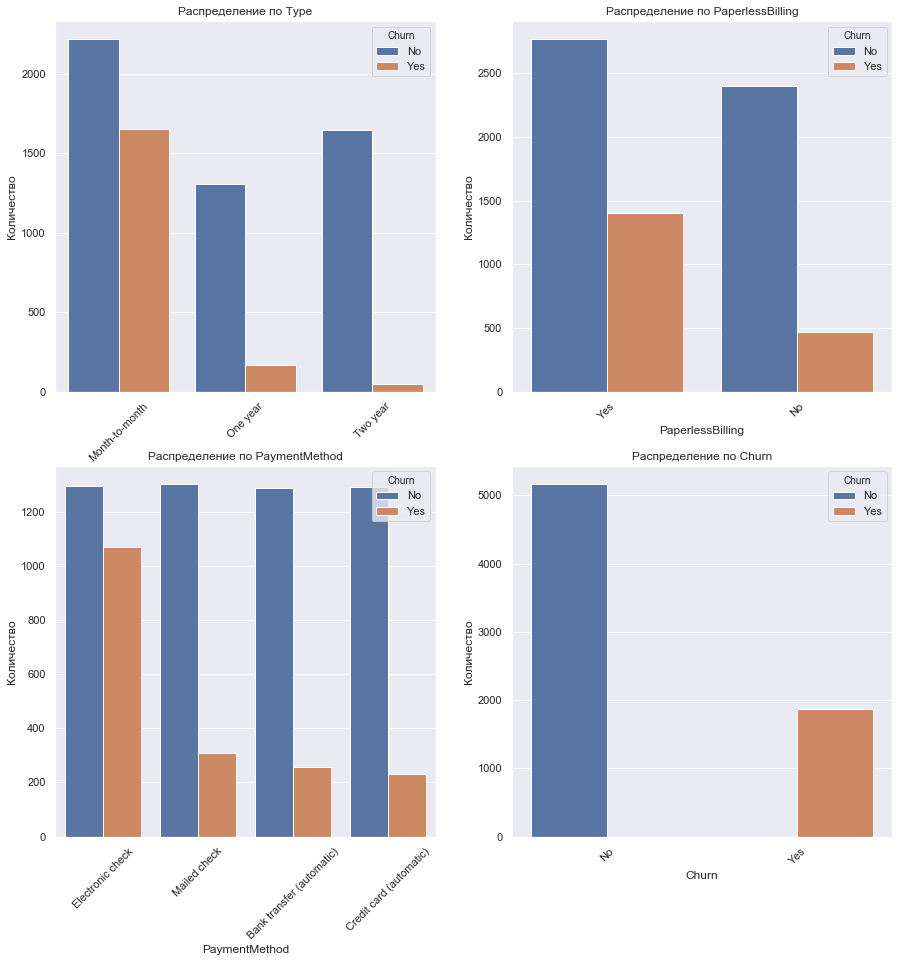

In [106]:
categorial_countplot(df_contract, df_contract_categorial, 2, 2, 15, 45)

Выводы:
- Чаще уходят кто оплачивает помесячно
- Оплачивающие по средством **PaperlessBilling** более склонны к уходу, чем те, кто оплачивает по бумаге
- У Electronic check самый высокий отток, почти равный лояльным. Вероятно, с системой онлайн оплаты есть проблемы.

Создадим ДатаФрейм из 2 признаков ДатаФрейма `df_contract` - **customerID**, **Churn**  

In [107]:
df_customerID_churn = pd.DataFrame(df_contract.loc[:, ['customerID', 'Churn']])

Объединим следующие таблицы по **customerID**:
- `df_personal` и `df_customerID_churn`;
- `df_internet` и `df_customerID_churn`;
- `df_phone` и `df_customerID_churn`.

In [108]:
df_personal_churn =  df_personal.merge(df_customerID_churn, on='customerID')
df_personal_churn

,customerID,gender,SeniorCitizen,Partner,Dependents,Churn
0,7590-VHVEG,Female,0,Yes,No,No
1,5575-GNVDE,Male,0,No,No,No
2,3668-QPYBK,Male,0,No,No,Yes
3,7795-CFOCW,Male,0,No,No,No
4,9237-HQITU,Female,0,No,No,Yes
...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,No
7039,2234-XADUH,Female,0,Yes,Yes,No
7040,4801-JZAZL,Female,0,Yes,Yes,No
7041,8361-LTMKD,Male,1,Yes,No,Yes


In [109]:
df_internet_churn =  df_internet.merge(df_customerID_churn, on='customerID')
df_internet_churn

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes,No
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No,Yes


In [110]:
df_phone_churn =  df_phone.merge(df_customerID_churn, on='customerID')
df_phone_churn

,customerID,MultipleLines,Churn
0,5575-GNVDE,No,No
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,No
...,...,...,...
6356,2569-WGERO,No,No
6357,6840-RESVB,Yes,No
6358,2234-XADUH,Yes,No
6359,8361-LTMKD,Yes,Yes


Определим категории в **df_personal** и сохраним в **personal_churn_cat**

In [111]:
personal_churn_cat = df_personal_churn.columns[1:5]
personal_churn_cat

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Построим распределения по этим данным:

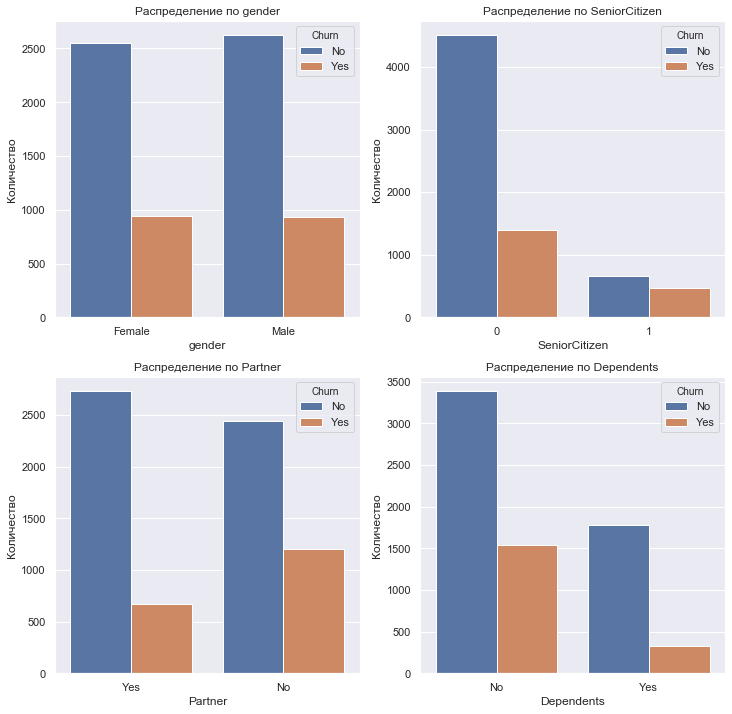

In [112]:
categorial_countplot(df_personal_churn, personal_churn_cat, 2, 2, 12, 0)

Выводы:
- По полу практически нет различий
- Пенсионеры гораздо чаще уходят(практически равно лояльным), вероятно не зависящих от компании причин
- Одиночки чаще уходят из компании, чем в паре. Определяет непостоянство одиночек в целом.
- С детьми более лояльные клиенты, т.к. стремятся к постоянству.

Сделаем тоже самое для **df_internet** и **df_phone**, построим графики

In [113]:
internet_churn_cat = df_internet_churn.columns[1:8]
internet_churn_cat

Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [114]:
phone_churn_cat = df_phone.columns[1]
phone_churn_cat

'MultipleLines'

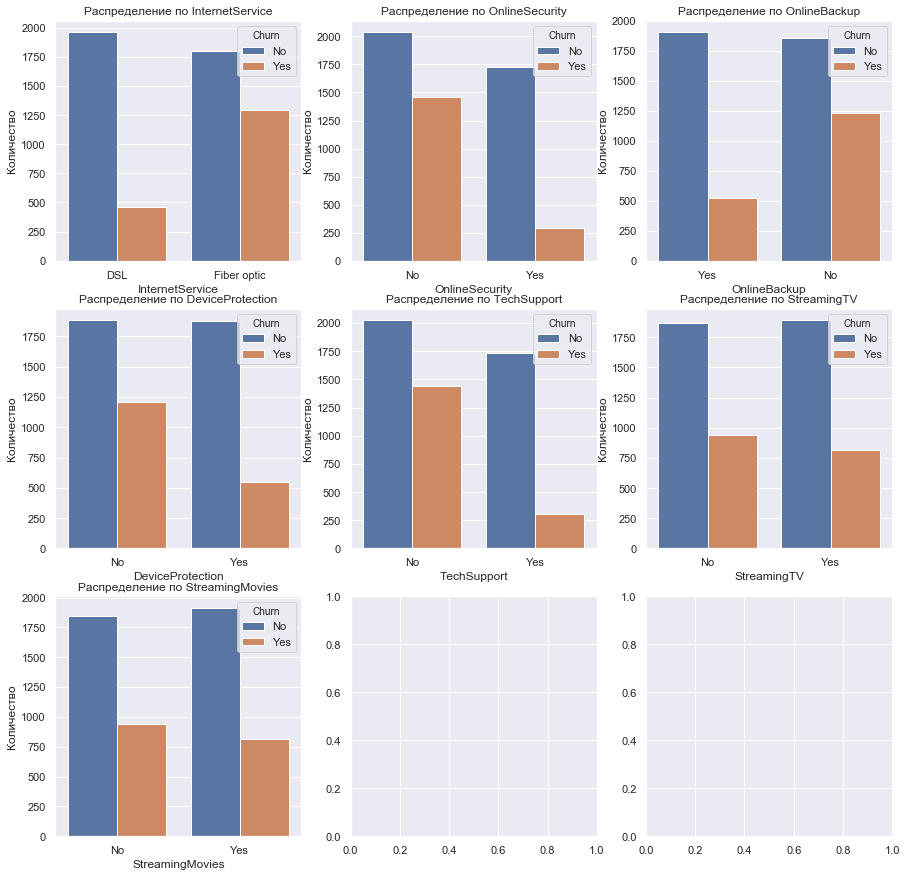

In [115]:
categorial_countplot(df_internet_churn, internet_churn_cat, 3, 3)

Выводы:
- Пользователи DSL более консервативны и лояльны, чем более прогрессивные пользователи оптики
- Пользователи блокировки небезопасных сайтов(OnlineSecurity), резервного копирования данных(OnlineBackup), антивируса(DeviceProtection) и выделенной линии технической поддержки(TechSupport) менее склонны к уходу, значит более довольны качеством этих услуг, чем те у кого их нет.
- Наличие стримингового телевидения (StreamingTV) и каталога фильмов (StreamingMovies) почти не влияет на уход.


Построим распределение по подключению телефонного аппарата к нескольким линиям одновременно.

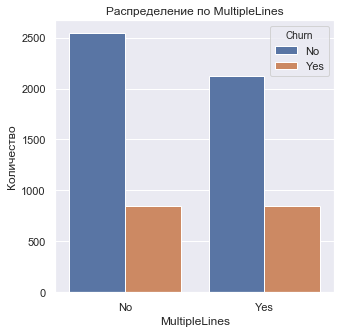

In [116]:
categorial_countplot(df_phone_churn, phone_churn_cat, 1, 1, size=5, rotation=0)

Выводы:
- Есть основание полагать, что данный признак не оказыват на уход клиента

Посмотрим на 2 группы - лояльных и ушедших в разрезе пользователей телефонии и интернета.  
Для этого объеденим `df_contract` и `df_internet`, `df_contract` и `df_phone`

In [117]:
df_internet_users = df_contract.merge(df_internet, on='customerID', how='outer')
df_phone_users = df_contract.merge(df_phone, on='customerID', how='outer')

Не пользующиеся это NaN. Заполним пропуски:

In [118]:
df_internet_users['InternetService'] = df_internet_users['InternetService'].fillna(-1)
df_phone_users['MultipleLines'] = df_phone_users['MultipleLines'].fillna(-1)

df_internet_users['internet_user'] = df_internet_users['InternetService'].apply(lambda x: 0 if x == -1 else 1)
df_phone_users['df_phone_users'] = df_phone_users['MultipleLines'].apply(lambda x: 0 if x == -1 else 1)

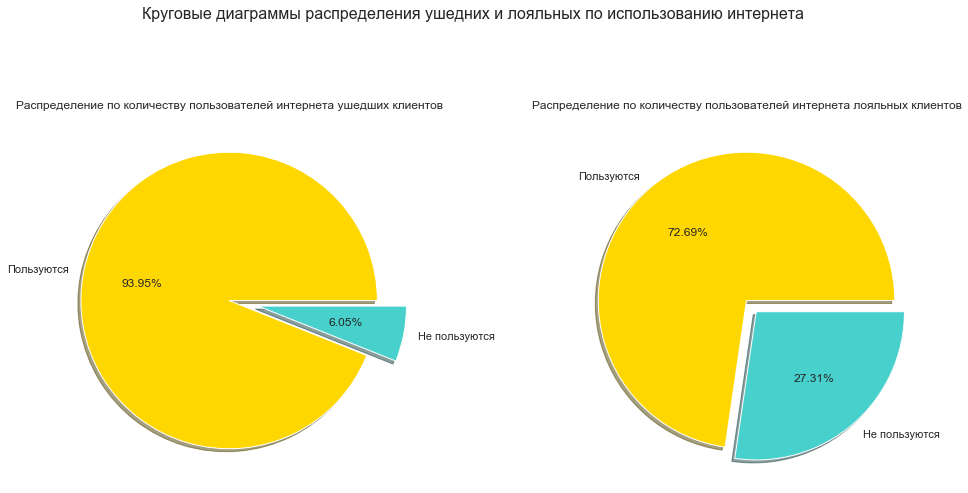

In [132]:
plt.figure(1, figsize=(17,15))
the_grid = GridSpec(2, 2)

colors = ['gold', 'mediumturquoise']


plt.subplot(the_grid[0, 0], aspect=1, title='Распределение по количеству пользователей интернета ушедших клиентов')
plt.pie(df_internet_users[df_internet_users['Churn'] == 'Yes']['internet_user'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.2))


plt.subplot(the_grid[0, 1], aspect=1, title='Распределение по количеству пользователей интернета лояльных клиентов')
plt.pie(df_internet_users[df_internet_users['Churn'] == 'No']['internet_user'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.1))

plt.suptitle('Круговые диаграммы распределения ушедних и лояльных по использованию интернета', fontsize=16)


plt.show()

Тоже самое для телефонии:

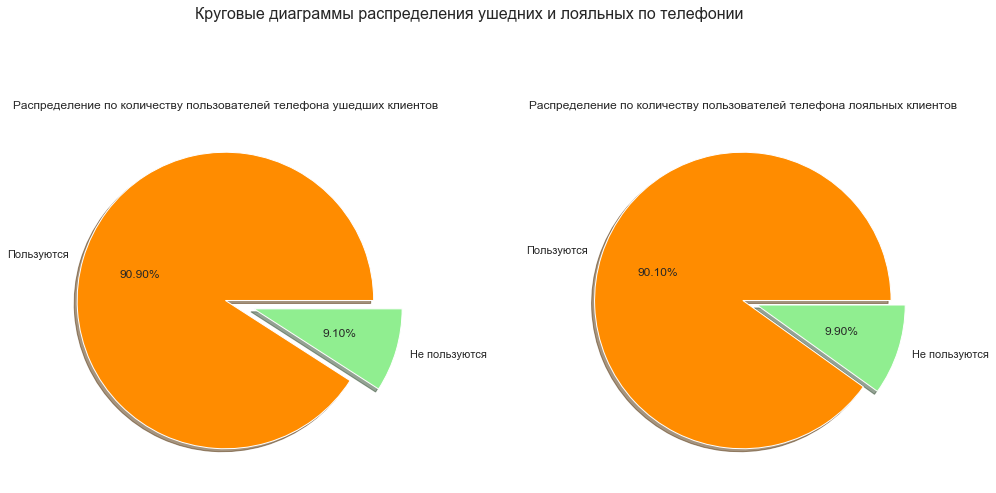

In [136]:
plt.figure(1, figsize=(17,15))
the_grid = GridSpec(2, 2)

colors = ['darkorange', 'lightgreen']


plt.subplot(the_grid[0, 0], aspect=1, title='Распределение по количеству пользователей телефона ушедших клиентов')
plt.pie(df_phone_users[df_phone_users['Churn'] == 'Yes']['df_phone_users'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.2))


plt.subplot(the_grid[0, 1], aspect=1, title='Распределение по количеству пользователей телефона лояльных клиентов')
plt.pie(df_phone_users[df_phone_users['Churn'] == 'No']['df_phone_users'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.1))

plt.suptitle('Круговые диаграммы распределения ушедних и лояльных по телефонии', fontsize=16)

plt.show()

Выводы:
- Пользователей интернета у ушедшим клиентов выше, чем у лояльных. Вероятно, там молодое поколение в большей части
- По телефонии распределение примерно одинаково.

### Выводы по главе 1:
> - Чаще уходят в основном те, кто получает большие счета за услуги и уходят в основном на первых месяцах
- Чаще уходят кто оплачивает помесячно и оплачивающие по средством PaperlessBilling
- У Electronic check высокий отток, почти равный лояльным. Вероятно, с системой онлайн оплаты есть проблемы
- Одиночки чаще уходят из компании, чем в паре и с детьми. Определяет непостоянство одиночек в целом
- Пользователи DSL более консервативны и лояльны, чем более прогрессивные пользователи оптики
- Пользователи блокировки небезопасных сайтов(OnlineSecurity), резервного копирования данных(OnlineBackup), антивируса(DeviceProtection) и выделенной линии технической поддержки(TechSupport) менее склонны к уходу, значит более довольны качеством этих услуг, чем те у кого их нет.
- Пользователей интернета у ушедшим клиентов выше, чем у лояльных. Вероятно, там молодое поколение в большей части

## Глава 2. Подготовка данных для моделей

Объеденим все таблицы, используя `merge()`, по стобцу **customerID** и тип слияния **outer** 

In [51]:
df_full = df_contract.merge(df_personal, on='customerID', how='outer') \
                     .merge(df_internet, on='customerID', how='outer') \
                     .merge(df_phone, on='customerID', how='outer')
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration_in_days,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,No,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Yes,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,No,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Yes,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Заменим значения целевого признака на (0, 1):

In [52]:
df_full['Churn'] = df_full['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

### Features engineering

Добавим еще два признака:
- **constant_person** - постоянные люди, они оплачивают счета на 1, 2 года вперед
- **vip_client** - клиенты, тратящие больше 3 квантиля по месячным отчислениям и длительностью контракта больше 1 года. 

Определим **constant_person**:

In [53]:
df_full['constant_person'] =  df_full['Type'].apply(lambda x: 0 if x == 'Month-to-month' else 1)

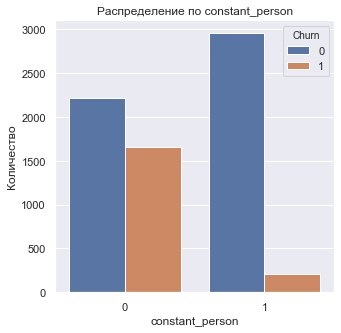

In [54]:
categorial_countplot(df_full, 'constant_person', 1, 1, 5)

- "Непостоянные" гораздо более склонны к уходу/смене оператора

Определим **vip_client**:

In [55]:
quantile_3 =  df_full['MonthlyCharges'].quantile(.75)
quantile_3

89.85

In [56]:
def vip_client(row):
    MonthlyCharges = row['MonthlyCharges']
    duration_in_days = row['duration_in_days']

    if MonthlyCharges > quantile_3 and duration_in_days > 365:
        return 'Yes'

    return 'No'

df_full['vip_client'] = df_full.apply(vip_client, axis=1)

In [57]:
df_full['vip_client'].value_counts()

No     5505
Yes    1538
Name: vip_client, dtype: int64

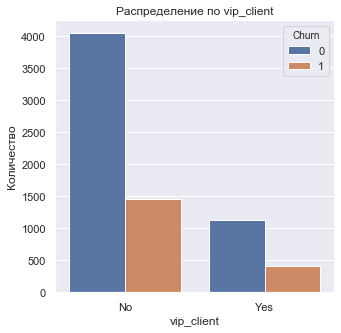

In [58]:
categorial_countplot(df_full, 'vip_client', 1, 1, 5)

- Разницы особо нет, уходят и тех практически с одинаковой частотой

Удалим не нужные признаки для обучения:
- customerID
- BeginDate
- EndDate

In [59]:
df_full = df_full.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

Чтобы преобразовать категориальные признаки в численные поможет техника прямого кодирования (One-Hot Encoding, OHE).
Для прямого кодирования в библиотеке pandas есть функция `pd.get_dummies()`  
чтобы избежать дамми-ловушки, используем аргумент `drop_first=True`

In [60]:
df_ohe = pd.get_dummies(df_full, drop_first=True)
df_ohe

,MonthlyCharges,TotalCharges,duration_in_days,Churn,SeniorCitizen,constant_person,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,vip_client_Yes
0,29.85,29.85,31,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,56.95,1889.50,1036,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0
2,53.85,108.15,61,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0
3,42.30,1840.75,1371,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0
4,70.70,151.65,61,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,730,0,0,1,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0
7039,103.20,7362.90,2191,0,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,1,1,1
7040,29.60,346.45,337,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0
7041,74.40,306.60,123,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0


Разделим датафрейм на 2 части: обучающую и тестовую выбороки в пропорциях 4:1, используя функцию `train_test_split` из библиетеки `sklearn.model_selection`  

In [61]:
df_train, df_test = train_test_split(df_ohe, test_size=0.2, random_state=12345)

In [62]:
df_train.shape, df_test.shape

((5634, 24), (1409, 24))

Разделим выборки на `X` -  признаки и `y` — целевой признак.

In [63]:
X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn']
X_test = df_test.drop(['Churn'], axis=1)
y_test = df_test['Churn']

Для того, чтобы отмаштабировать признаки, воспользуемся одним из методов масштабирования — стандартизации данных.  
В sklearn есть отдельная структура для стандартизации данных — **StandardScaler**  
Преобразуем обучающую и тестовую выборки функцией `transform()`.

In [64]:
numeric_features = X_train.iloc[:, :3].columns
numeric_features

Index(['MonthlyCharges', 'TotalCharges', 'duration_in_days'], dtype='object')

In [65]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Посмотрим на отношение лояльных к ушедшим

In [66]:
scale_pos_weight = round((len(y_train[y_train == 0]) / 
                          len(y_train[y_train == 1])), 3)
scale_pos_weight

2.781

Целевой признак ухода представлен в меньшей степени. Многие модели умеют работать с дисбалансом, но пойдем по другому пути. 
Чтобы сбаллансировать классы и увеличить количество данных, напишем функцию `upsample(features, target, repeat)` для формирования сблалансированной выборки:

In [67]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

Применим `upsample` к обучающей выборке и проверим результат

In [68]:
X_train_ups, y_train_ups = upsample(X_train, y_train, 3)

print(X_train_ups.shape)
print(y_train_ups.shape)

(8614, 23)
(8614,)


In [69]:
scale_pos_weight = round((len(y_train_ups[y_train_ups == 0]) / 
                          len(y_train_ups[y_train_ups == 1])), 3)
scale_pos_weight

0.927

### Выводы по главе 2:
 
> 1 - Дисбаланс в целевом признаке был устранен  
2 - Категориальеные признаки перевели в численные через **One-Hot Encoding**, количественные нормировали через **StandardScaler**  
3 - Созданы еще 2 признака(помимо **duration_in_days**)  
4 - Данные подготовлены для обучения

## Глава 3. Обучение моделей

В качестве baseline - **LogisticRegression** и **RandomForestClassifier**.  
Для более лучшего результата модели градиентного бустинга - **CatBoostClassifier, XGBClassifier, LGBMClassifier**  
Импортируем модели:

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Для подбора гиперпараметров будем использовать **GridSearchCV**, для кросс-валидации при подборе гиперпараметров **ShuffleSplit** сразюиеним на 3 фолда и оценке на 1/5 части  выборки.    
Напишем функцию `model_learning` - принимающая модель и сетку параметров, обучает и возвращает лучшую модель на обучениии.

In [308]:
def model_learning(model, parameters):
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(X_train_ups, y_train_ups)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    return grid_model.best_estimator_

Для оценки качества модели по ROC-AUC и Accuracy напишем функцию `test_scoring`, принимает обученную модель и дает оценки на тестовой выборке и строит ROC-AUC кривую:

In [326]:
def test_scoring(model):
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    pred_test = model.predict(X_test)
    print('Accuracy: ', round(model.score(X_test, y_test), 3))
    print('Presicion: ', round(precision_score(y_test, pred_test), 3))
    print('Recall: ', round(recall_score(y_test, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(y_test, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

Для оценки важности признаков напишем функцию `feature_importance`, принимающая обученную модель и выводящая признаки, ранжированные по значимости для модели:

In [317]:
def feature_importance(model):
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Важность', fontsize=25, weight = 'bold')
    plt.ylabel('Признаки', fontsize=25, weight = 'bold')
    plt.title('Важность признаков', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

#### Baseline

**Логистическая регрессия**  
Подбор параметров:
- коэффициент регулиризации С - ограничивает рост весов при признаках

Обучим модель и оценим на тестовой выборке:

Лучшая оценка на валидации:  0.8491338288381968
Лучшие гиперпараметры модели на валидации:  {'C': 1.0535263157894736}
Лучшая модель:  LogisticRegression(C=1.0535263157894736, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:  0.732
Presicion:  0.501
Recall:  0.839
AUC-ROC:  0.842


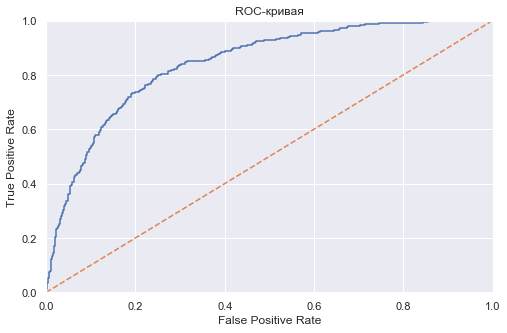

Wall time: 1.64 s


In [327]:
%%time
lr = LogisticRegression(random_state=12345, n_jobs=-1)
lr_param = {'C' : np.linspace(0.001, 10, 20)}

lr_fitted = model_learning(lr, lr_param)
test_scoring(lr_fitted)

Для модели важность признака определяется абсолютным значением его коэффициента.  
Посчитаем долю влияния каждого признака на предсказание модели **LogisticRegression**, воспользуясь функцией softmax:

In [312]:
m = softmax(abs(lr_fitted.coef_))
m[0]

array([0.03689452, 0.06106142, 0.11329225, 0.0409448 , 0.06255876,
       0.02994673, 0.06420403, 0.04492271, 0.03243832, 0.04152729,
       0.03460167, 0.02988449, 0.02984963, 0.0378563 , 0.04651632,
       0.04288654, 0.03239808, 0.03103282, 0.04004137, 0.038111  ,
       0.03663512, 0.03078671, 0.04160912])

У модели **LogisticRegression** нет метода feature_importances_, воспользуемся готовым кодом и заменим значение на полученное выше

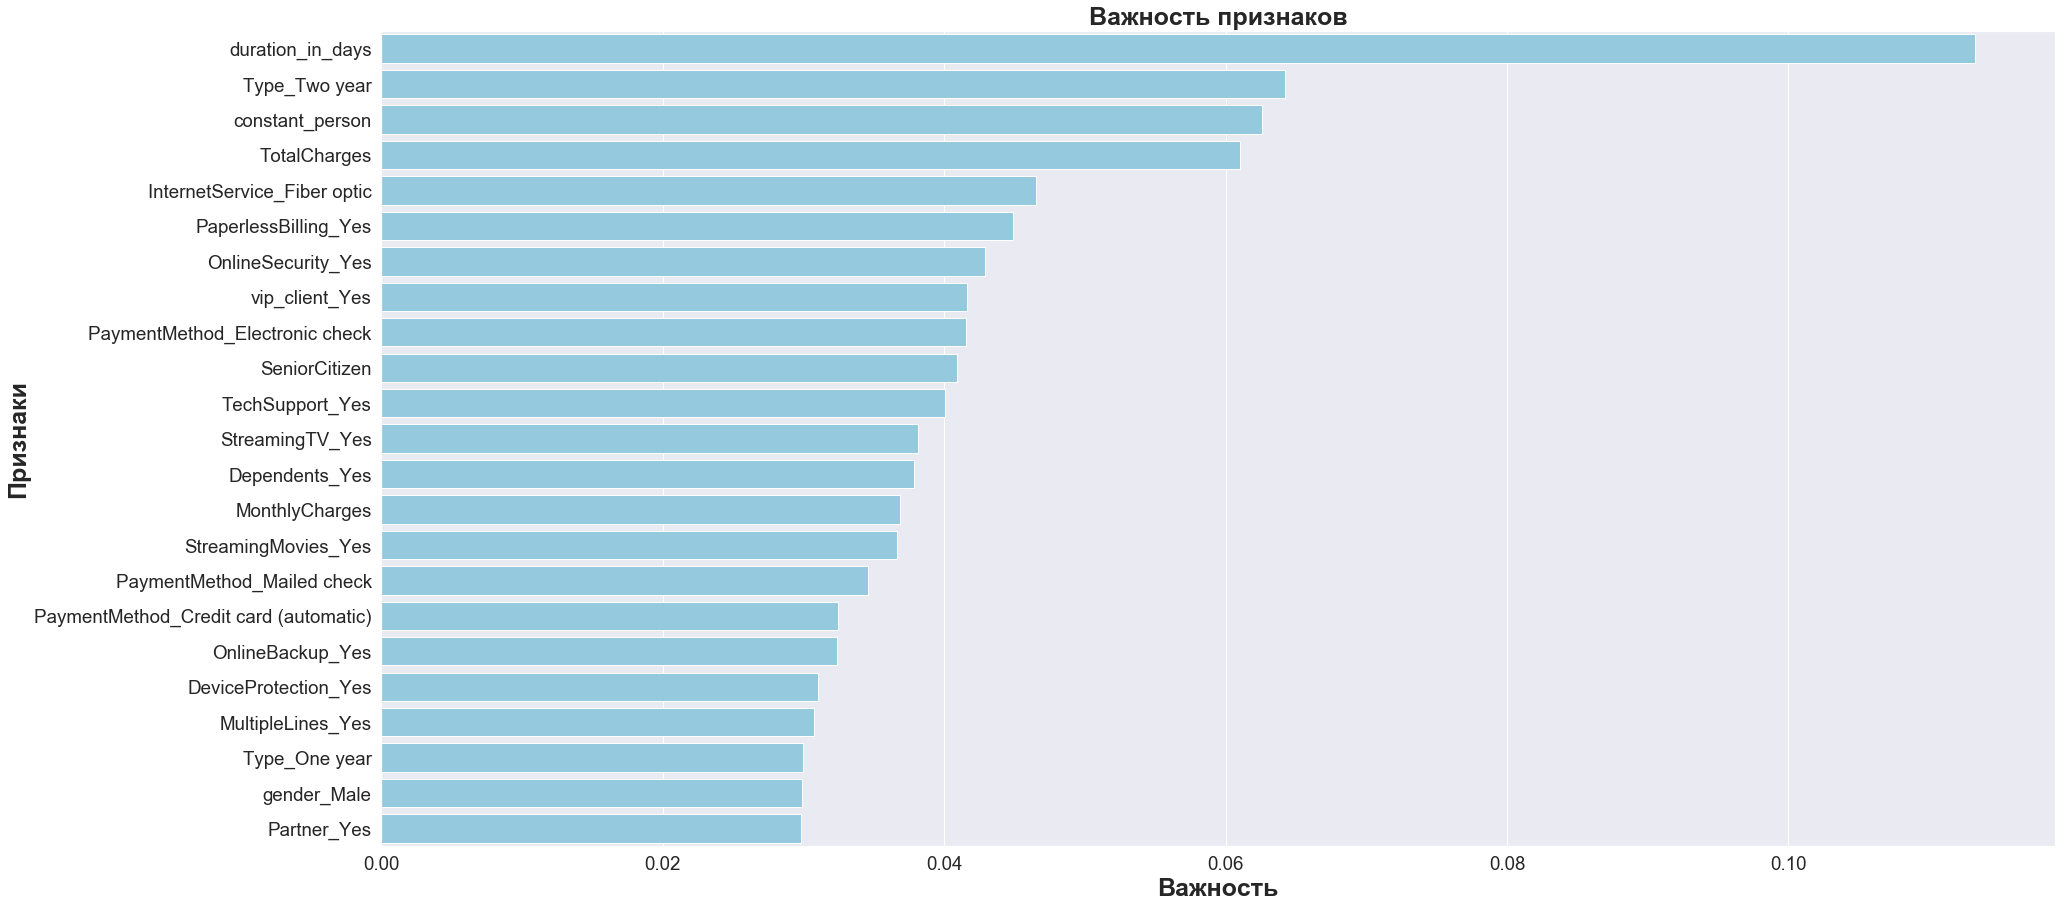

None

,Features,Gini-Importance
0,duration_in_days,0.113292
1,Type_Two year,0.064204
2,constant_person,0.062559
3,TotalCharges,0.061061
4,InternetService_Fiber optic,0.046516
5,PaperlessBilling_Yes,0.044923
6,OnlineSecurity_Yes,0.042887
7,vip_client_Yes,0.041609
8,PaymentMethod_Electronic check,0.041527
9,SeniorCitizen,0.040945


In [325]:
feats = {}
for feature, importance in zip(X_train.columns, m[0]):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Лучшие гиперпараметры:
- {'C': 1.0535263157894736}  

Метрики:
- Accuracy:  0.732
- Presicion:  0.501
- Recall:  0.839
- **AUC-ROC:  0.842**

Топ-5 важных признаков модели:
- duration_in_days	
- Type_Two year	
- constant_person
- TotalCharges
- InternetService_Fiber optic

**Случайных лес**  
Подбор параметров:
- n_estimators - количество решающих деревьев
- max_depth - глубина дерева
- min_samples_leaf - минимальное количество примеров для образования листа
- min_samples_split - минимальное количество примеров для образования узла

Обучим модель и оценим на тестовой выборке:

Лучшая оценка на валидации:  0.9798474351876737
Лучшие гиперпараметры модели на валидации:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Лучшая модель:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Accuracy:  0.803
Presicion:  0.636
Recall:  0.623
AUC-ROC:  0.846


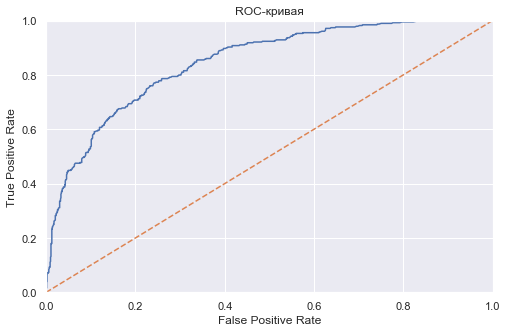

Wall time: 7min 22s


In [337]:
%%time
rf = RandomForestClassifier(random_state=12345, n_jobs=-1)
rf_param = {'n_estimators': [300, 500, 1000],
            'max_depth': [None, 10, 15],
            'min_samples_leaf': np.arange(1, 6, 2),
            'min_samples_split': np.arange(2, 7, 2)}

rf_fitted = model_learning(rf, rf_param)
test_scoring(rf_fitted)

Выведем важные признаки модели:

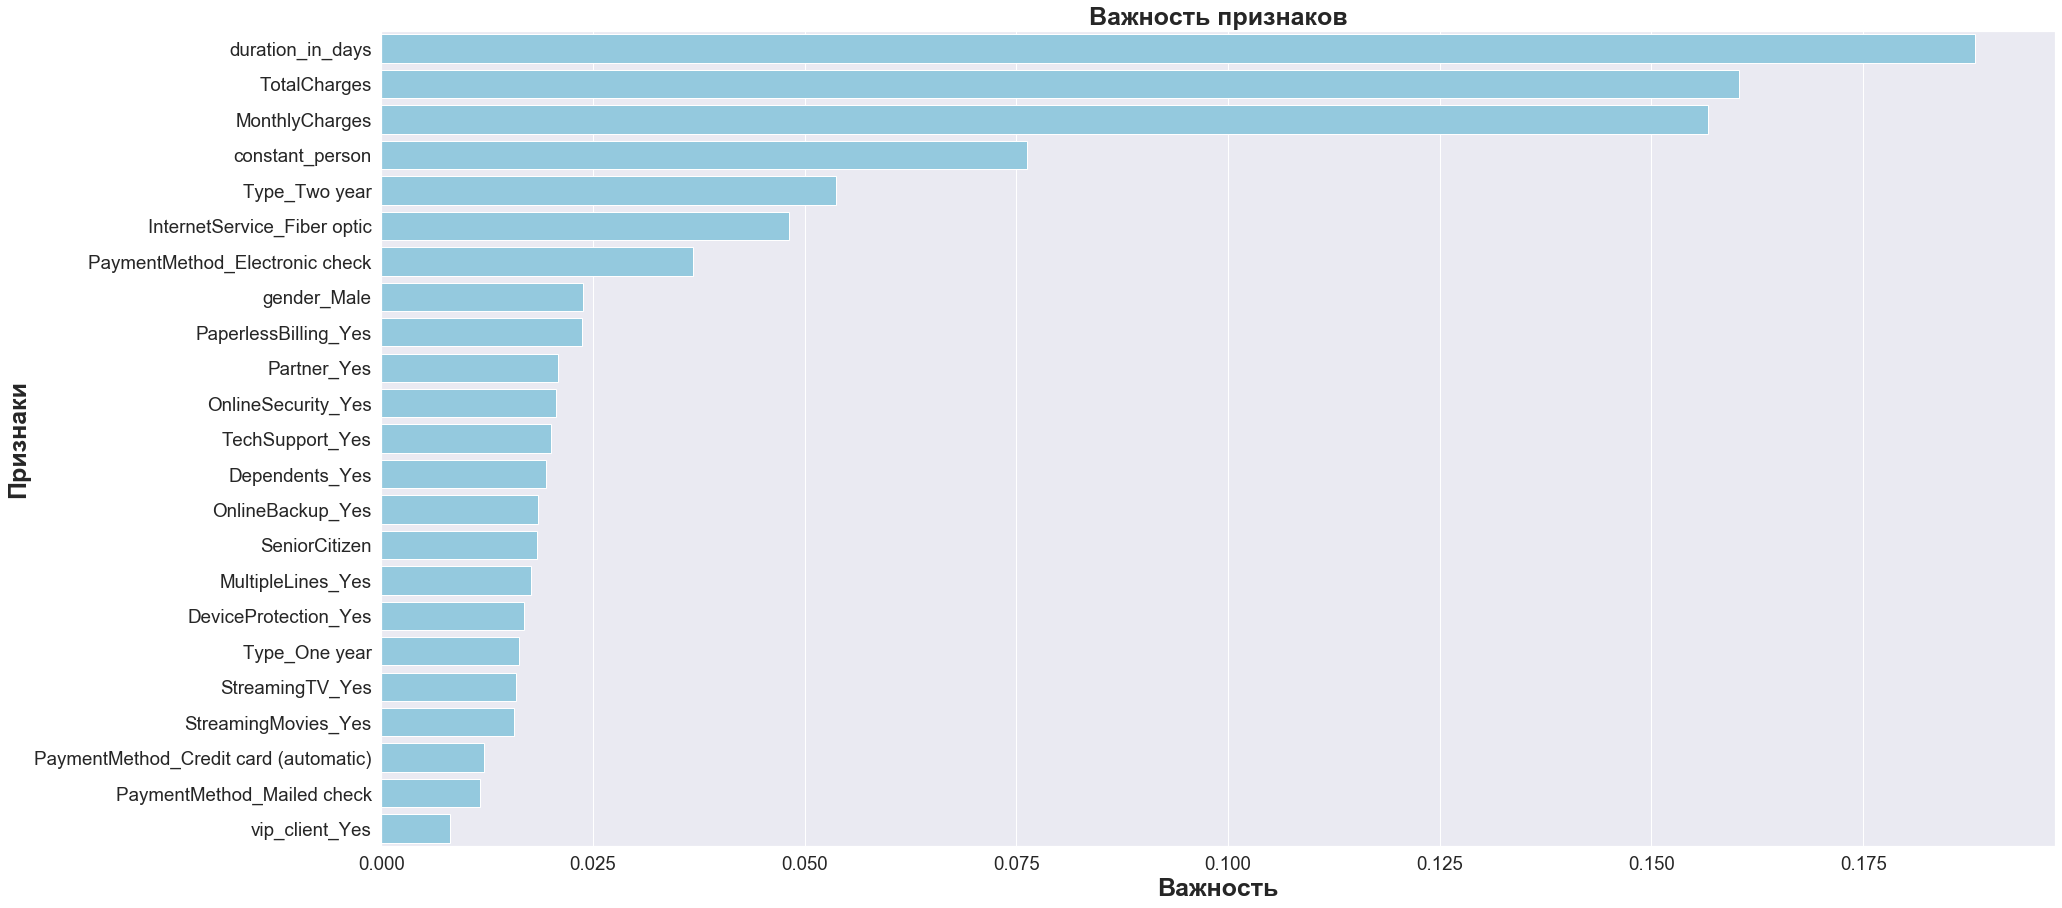

None

,Features,Gini-Importance
0,duration_in_days,0.188261
1,TotalCharges,0.160291
2,MonthlyCharges,0.156630
3,constant_person,0.076208
4,Type_Two year,0.053761
5,InternetService_Fiber optic,0.048167
6,PaymentMethod_Electronic check,0.036820
7,gender_Male,0.023884
8,PaperlessBilling_Yes,0.023755
9,Partner_Yes,0.020889


In [319]:
feature_importance(rf_fitted)

Лучшие гиперпараметры:
- {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

Метрики:
- Accuracy:  0.803
- Presicion:  0.636
- Recall:  0.623
- **AUC-ROC:  0.846**

Топ-5 важных признаков модели:
- duration_in_days	
- TotalCharges
- MonthlyCharges
- constant_person
- Type_Two year

Разница между LogisticRegression и RandomForestClassifier по метрике ROC-AUC практически отсутствует, но скорость обучения логистической регрессии несоизмеримо выше, что и логично она же одна.

#### Модели градиентного бустинга

**CatBoost**  
Подбор параметров:
- n_estimators - количество решающих деревьев
- learning_rate - коэффициент шага антиградиента  
- max_depth - глубина дерева
- l2_leaf_reg - коеффициент при l2 регуризации  

Обучим модель и оценим на тестовой выборке:

Лучшая оценка на валидации:  0.9849900339955702
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x000001AB86825C08>
Accuracy:  0.842
Presicion:  0.719
Recall:  0.675
AUC-ROC:  0.89


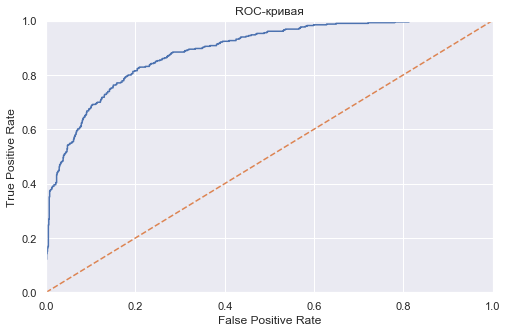

Wall time: 23min 34s


In [361]:
%%time
CatBoost_clf = CatBoostClassifier(random_state=12345, verbose=0)
CatBoost_clf_param = {'n_estimators': [300, 500, 1000],
                      'learning_rate': [0.01, 0.1, 1],
                      'max_depth': [1, 5, 9],
                      'l2_leaf_reg': [1, 3]}

CatBoost_fitted = model_learning(CatBoost_clf, CatBoost_clf_param)
test_scoring(CatBoost_fitted)

Выведем важные признаки модели:

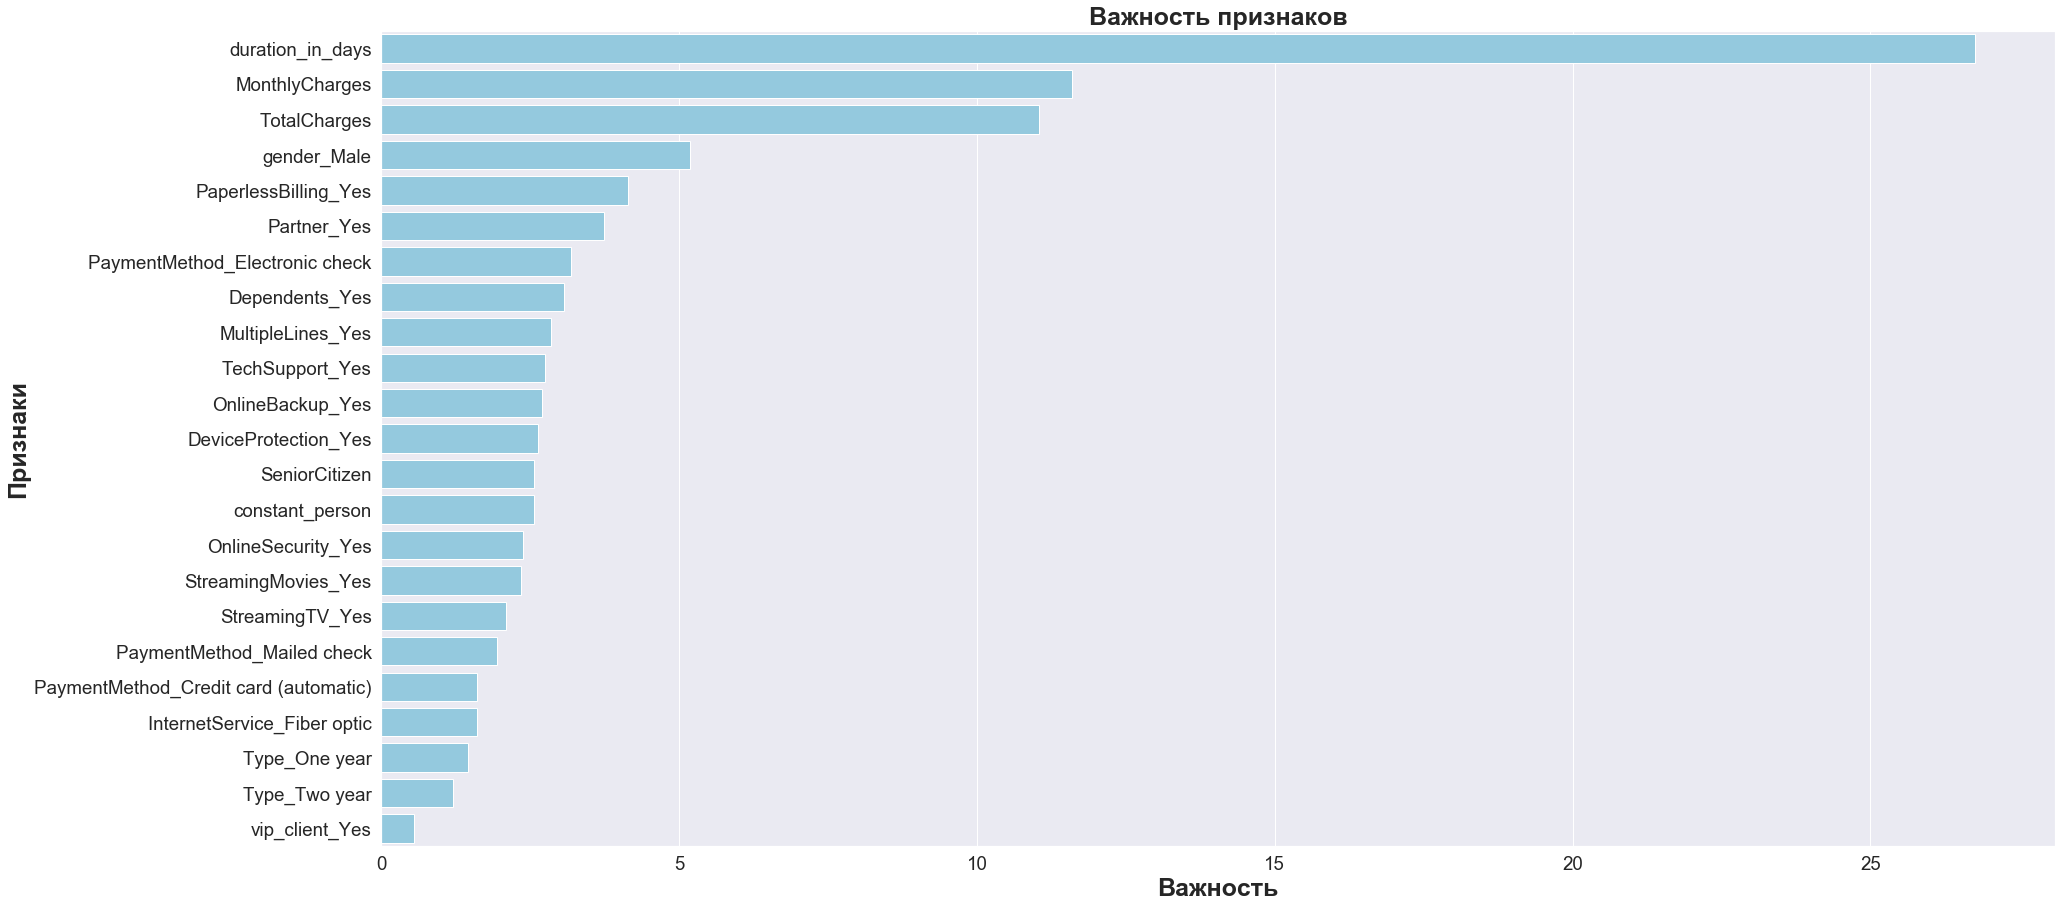

None

,Features,Gini-Importance
0,duration_in_days,26.762605
1,MonthlyCharges,11.597061
2,TotalCharges,11.045371
3,gender_Male,5.189523
4,PaperlessBilling_Yes,4.148784
5,Partner_Yes,3.732694
6,PaymentMethod_Electronic check,3.191692
7,Dependents_Yes,3.071453
8,MultipleLines_Yes,2.851488
9,TechSupport_Yes,2.754405


In [362]:
feature_importance(CatBoost_fitted)

Лучшие гиперпараметры:
- {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}

Метрики:
- Accuracy:  0.842
- Presicion:  0.719
- Recall:  0.675
- **AUC-ROC:  0.89**

Топ-5 важных признаков модели:
- duration_in_days	
- TotalCharges
- MonthlyCharges
- gender_Male
- PaperlessBilling_Yes

**XGBoost**    
Подбор параметров:
- n_estimators - количество решающих деревьев
- learning_rate - коэффициент шага антиградиента  
- max_depth - глубина дерева
- l2_leaf_reg - коеффициент при l2 регуризации  

Обучим модель и оценим на тестовой выборке:

Лучшая оценка на валидации:  0.9813343753308668
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Лучшая модель:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              l2_leaf_reg=1, learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy:  0.85
Presicion:  0.73
Recall:  0.699
AUC-ROC:  0.895


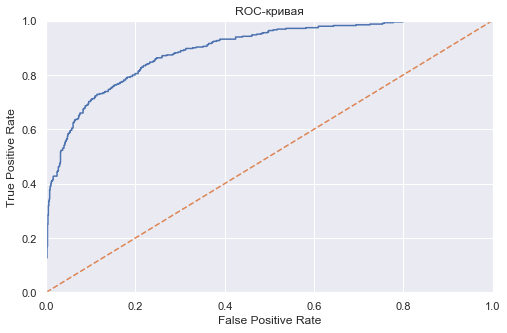

Wall time: 10min 38s


In [359]:
%%time
xgb_clf = XGBClassifier(random_state=12345, n_jobs=-1)
xgb_clf_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}

xgb_clf_fitted = model_learning(xgb_clf, xgb_clf_param)
test_scoring(xgb_clf_fitted)

Выведем важные признаки модели:

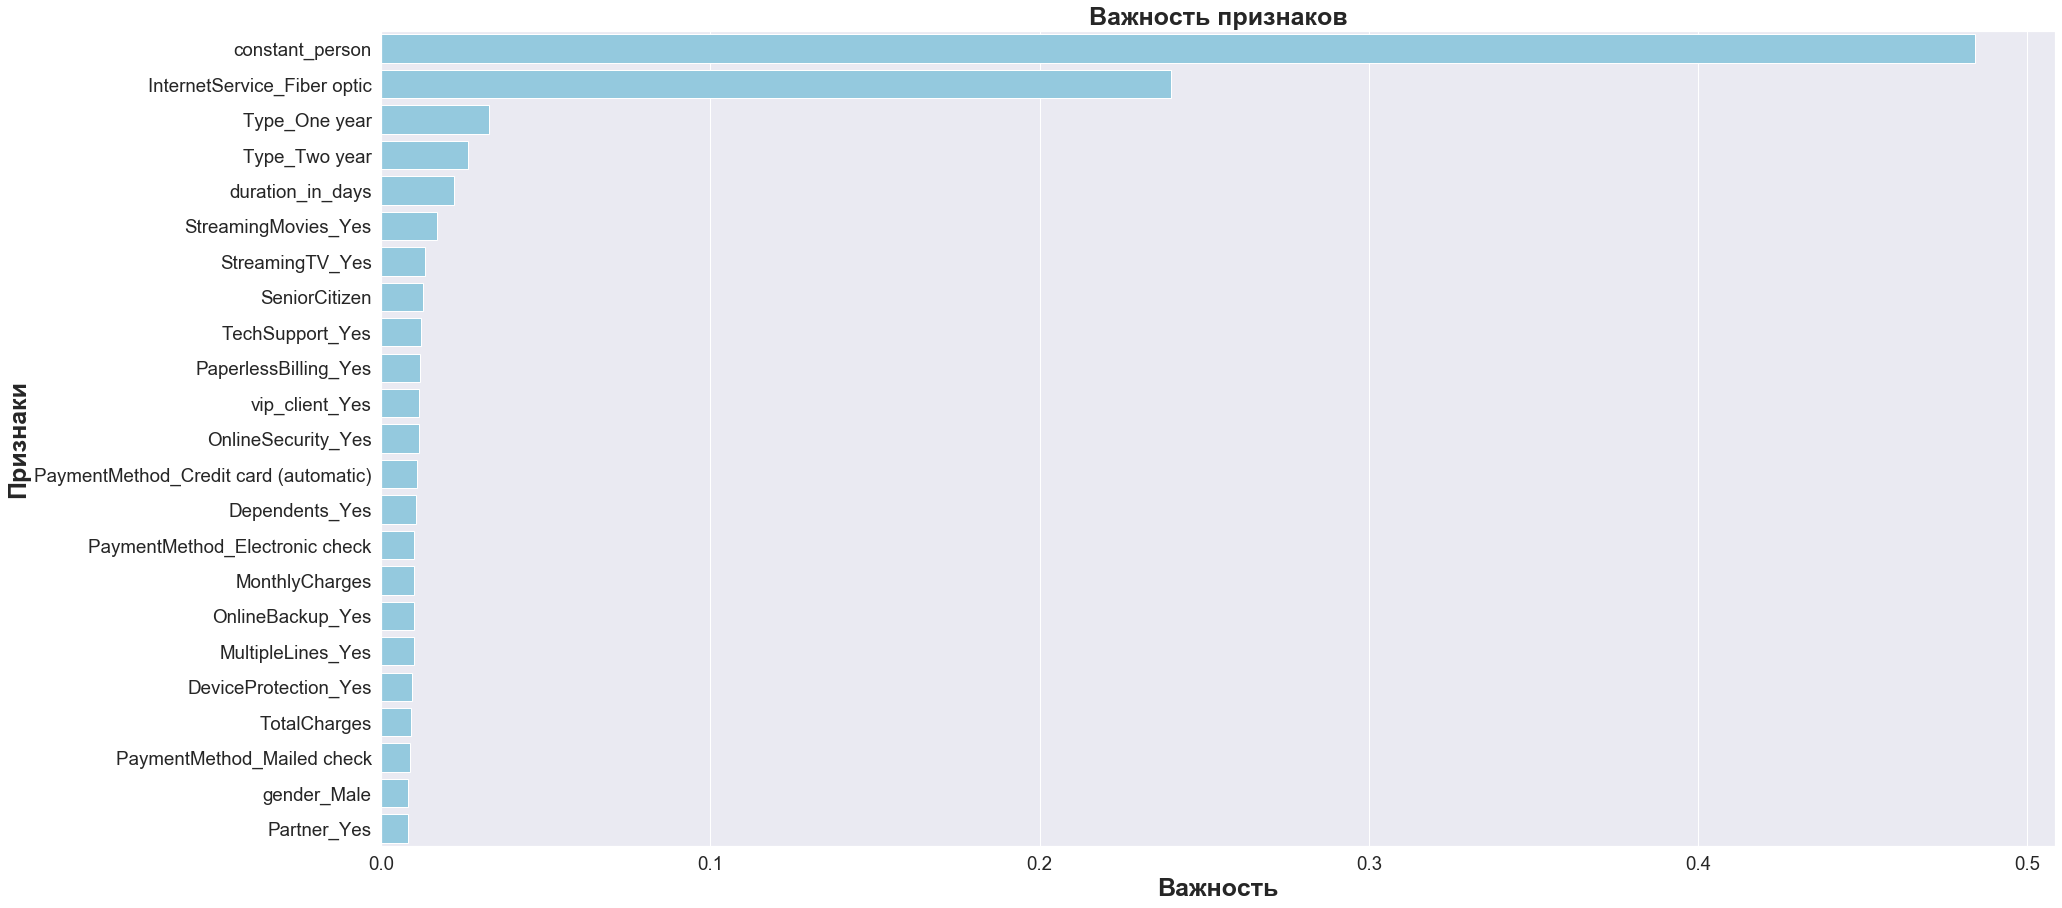

None

,Features,Gini-Importance
0,constant_person,0.484299
1,InternetService_Fiber optic,0.239934
2,Type_One year,0.032597
3,Type_Two year,0.026309
4,duration_in_days,0.022254
5,StreamingMovies_Yes,0.016814
6,StreamingTV_Yes,0.013336
7,SeniorCitizen,0.012696
8,TechSupport_Yes,0.012234
9,PaperlessBilling_Yes,0.011793


In [360]:
feature_importance(xgb_clf_fitted)

Лучшие гиперпараметры:
- {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}

Метрики:
- Accuracy:  0.85
- Presicion:  0.73
- Recall:  0.699
- **AUC-ROC:  0.895**

Топ-5 важных признаков модели:
- constant_person
- InternetService_Fiber optic
- Type_One year	
- Type_Two year	
- duration_in_days	

**LGBM**    
Подбор параметров:
- n_estimators - количество решающих деревьев
- learning_rate - коэффициент шага антиградиента  
- max_depth - глубина дерева
- l2_leaf_reg - коеффициент при l2 регуризации  

Обучим модель и оценим на тестовой выборке:

Лучшая оценка на валидации:  0.9854469553296418
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Лучшая модель:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', l2_leaf_reg=1, learning_rate=0.1,
               max_depth=9, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=12345, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Accuracy:  0.85
Presicion:  0.738
Recall:  0.683
AUC-ROC:  0.903


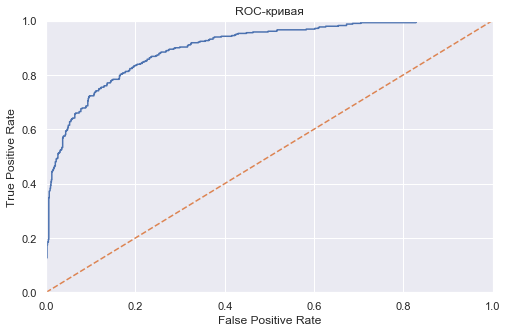

Wall time: 2min 19s


In [356]:
%%time
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=12345)
lgbm_clf_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}
    
lgbm_clf_fitted = model_learning(lgbm_clf, lgbm_clf_param)
test_scoring(lgbm_clf_fitted)

Выведем важные признаки модели:

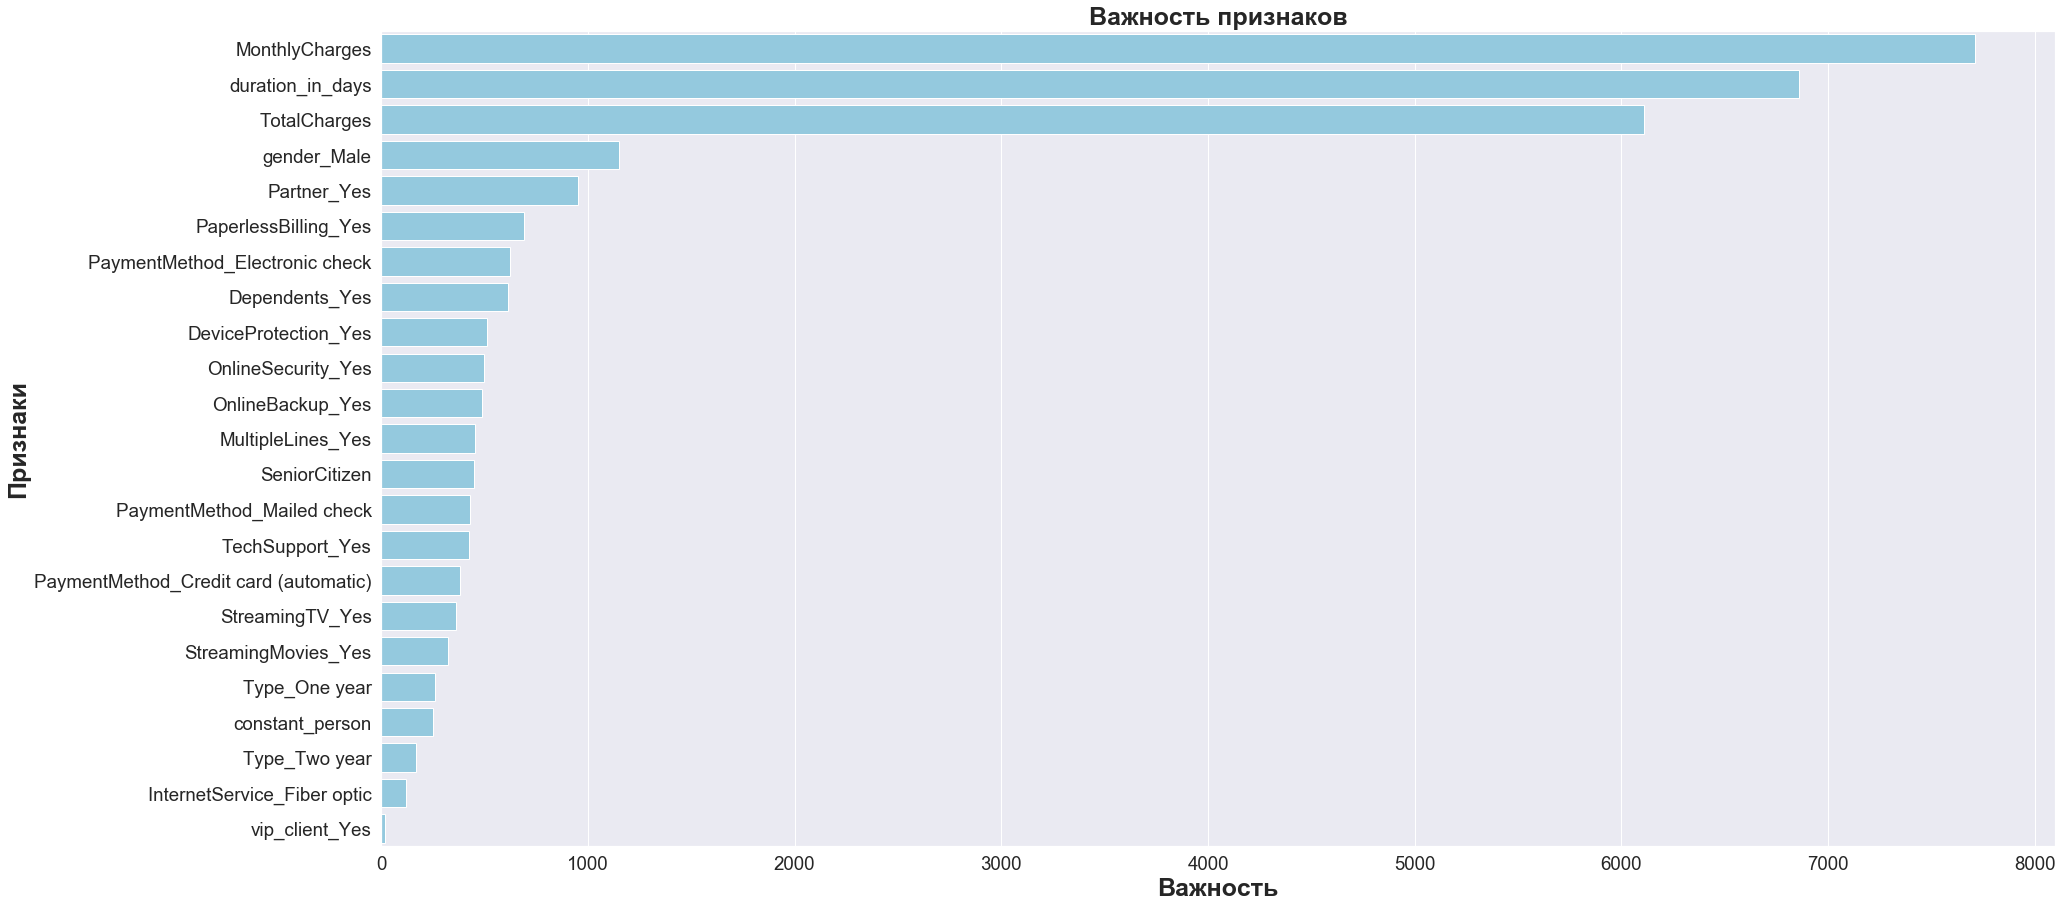

None

,Features,Gini-Importance
0,MonthlyCharges,7713
1,duration_in_days,6861
2,TotalCharges,6111
3,gender_Male,1151
4,Partner_Yes,950
5,PaperlessBilling_Yes,690
6,PaymentMethod_Electronic check,622
7,Dependents_Yes,615
8,DeviceProtection_Yes,510
9,OnlineSecurity_Yes,498


In [357]:
feature_importance(lgbm_clf_fitted)

Лучшие гиперпараметры:
- {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}

Метрики:
- Accuracy:  0.85
- Presicion:  0.738
- Recall:  0.683
- **AUC-ROC:  0.903**

Топ-5 важных признаков модели:
- MonthlyCharges	
- duration_in_days	
- TotalCharges	
- gender_Male	
- Partner_Yes	

По моделям градиентного бустинга можно сказать:
- качество по интересующим метрикам примерно одинаковое
    - Accuracy примерно: 0.85
    - AUC-ROC примерно: 0.9
- скорость обучения
    - CatBoost и XGBoost самое долгое, 23 мин и 10 мин соответственно
    - LGBM значительно быстрее обучается на этих данных - всего 2 мин.

Сведем все данные в таблицу:

In [71]:
data = {'Модель':['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier'], 
        'Presicion': [0.501, 0.636, 0.719, 0.73, 0.738],
        'Recall': [0.839, 0.623, 0.675, 0.699, 0.683],
        'Accuracy':[0.732, 0.803, 0.842, 0.85, 0.85],
        'AUC-ROC': [0.842, 0.846, 0.89, 0.895, 0.903],
        'Скорость обучения': ['1.64s', '7min 22s', '23min 34s', '10min 38s', '2min 19s']}

pd.DataFrame(data)

,Модель,Presicion,Recall,Accuracy,AUC-ROC,Скорость обучения
0,LogisticRegression,0.501,0.839,0.732,0.842,1.64s
1,RandomForestClassifier,0.636,0.623,0.803,0.846,7min 22s
2,CatBoostClassifier,0.719,0.675,0.842,0.890,23min 34s
3,XGBClassifier,0.730,0.699,0.850,0.895,10min 38s
4,LGBMClassifier,0.738,0.683,0.850,0.903,2min 19s


- ROC-кривая (или кривая ошибок) изображается в осях: по горизонтали доля ложноположительных ответов (FPR), а по вертикали — доля истинно положительных ответов (TPR). Чем график выше, тем больше значение TPR и лучше качество модели.   
- Accuracy показывает как часто модель ошибается  
- Полнота выявляет, какую долю положительных среди всех ответов выделила модель.  
- Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные.

### Выводы по главе 3:
> 1 - Логистическая регрессия уступает по интересующим метрикам качества (Accuracy, AUC-ROC) другим моделям с лесами, но выигрывает сильно во времени обучения  
2 - Случайный лес немного лучше, но дольше обучается, особенно когда много деревьев  
3 - Лучшие по качеству метрик модели градиентного бустинга, но у этого есть обратная сторона - долгое время обучения.  
4 - Лучшая модель по оценкам интересующих метрик - LGBM  
5 - Большинство моделей определило следующие признаки наиболее значимыми: 
    - MonthlyCharges	
    - duration_in_days	
    - TotalCharges

### Общий вывод:

> 1. Исследовательский анализ данных позволил определить группы пользователей, которые склонны к уходу. Даже без машинного обучения можно сформировать портреты лояльных и нелояльных клиентов и предпринять упреждающие событию действия, направленые на удержание клиента
- Машинное обучение позволяет видеть метрики вероятности ухода клиента. В нашем случае у моделей:
    - Accuracy примерно: 0.85
    - AUC-ROC примерно: 0.9  
    То есть с вероятностью 85% модели могут дать правильный прогноз 
- Лучшая модель по указанным метрикам и скорости обучения - **LGBM**.   
    Модель показала на тестовой выборке:
    - Accuracy: **0.850**
    - AUC-ROC: **0.903**  
- Обученная модель полностью справляется с поставленной заказчиком задачи (AUC-ROC >= 0.88)